# Distilling Sarcasm
> or: "how to teach GPT-4.1-nano and Ministral-3B how to be sarcastic"

This is an end-to-end example of **distillation**: squeezing the behaviors of a
larger model into a smaller model.

We're going to show how you can take an un-engineered prompt (`SYSTEM_PROMPT`)
as simple as:

> Clippy is a factual chatbot that is also sarcastic.

...and basically go from zero to a fine-tuned model 
*without having to generate your own training data!*

## Requirements
1. Go spin up base model deployments for all models you want to work with. In
   this notebook, I use `o3-mini`, `gpt-4.1`, `gpt-4.1-mini`, `gpt-4.1-nano`, 
   `gpt-4o`, `gpt-4o-mini`, `Ministral-3B`, and `DeepSeek-V3.1`. (You may also 
   need TPM quota in your subscription.)

2. Create and populate a `.env` file to simplify stuff. In it, put some Azure
   specific details:

```properties
FOUNDRY_PARENT_RESOURCE=<YOUR FOUNDRY PARENT RESOURCE>
FOUNDRY_API_KEY=<YOUR FOUNDRY API KEY>
AZURE_SUBSCRIPTION_ID=<YOUR AZURE SUBSCRIPTION ID>
AZURE_RESOURCE_GROUP=<YOUR AZURE RESOURCE GROUP>
```

3. Depending on how you run this notebook, you may need to pre-install a
   **Jupyter** environment. The `pip install` below will handle any other
   dependencies for you.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Environment Setup
First things first: we need an **Azure OpenAI** client instance.

In [2]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv(override=True)

client = OpenAI(
    base_url=f"https://{os.environ.get('FOUNDRY_PARENT_RESOURCE')}.openai.azure.com/openai/v1/",
    api_key=os.environ.get("FOUNDRY_API_KEY"),
)

We also want to keep an entire experiment run easily identifiable. A few bits of
randomness should be enough, so just generate a UUID and chop off its head 🪓.

In [3]:
# We'll create a "unique enough" identifier that lets us run this notebook
# multiple times and easily keep track of things each run creates.
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

## 0. Assembling Human Curated Data
We need a *gold standard* sample, not to train our model on, but to measure
the efficacy of our grader.

We'll use some pre-canned sarcasm examples from the **Azure OpenAI** tutorial
on [fine-tuning a GPT model](https://learn.microsoft.com/en-us/azure/ai-services/openai/tutorials/fine-tune?tabs=command-line).

The [baseline.jsonl](./baseline.jsonl) file contains the prompts from that
tutorial, but decomposed into a simple format of question/answer pairs.

In [4]:
# Peek at our baseline *gold standard* dataset.
import json

rows = 0
with open("./baseline.jsonl", "r") as f:
    for line in f.readlines():
        print(json.loads(line))
        rows += 1
        if rows >= 3:
            break

{'question': 'Who discovered Antarctica?', 'answer': "Some chaps named Fabian Gottlieb von Bellingshausen and Mikhail Lazarev, as if they don't teach that in every school!"}
{'question': 'What is the biggest ocean?', 'answer': "The Pacific Ocean. It's not like it's a small pond or anything."}
{'question': 'What is the largest planet?', 'answer': "It's called Jupiter, you might have heard of it...or not."}


## 1. Grading the Grader
The Grader is the lynchpin here, so it *must* be effective. 

Specifically, we'll use a **Score Model Grader** (aka `score_model` via the API).
It's job is to take a *prompt* and use it to derive a numeric *score*. We define
to decide if the score is "passing" or "failing", which we'll use as a simple
signal of quality.

> ℹ️ **Aside: Garbage In, Garbage Out**
> If you cannot explain to a reasoning model like `o3-mini` how to identify high 
> and low quality responses based on your objective, you have a *shaky foundation*
> from which to build upon.
>
> But keep in mind, `o3-mini` is a *reasoning* model. You do *not* need to give it
> fine-grained instructions, but you should give it a *clear objective*.



### 📃 Preparing our first Evaluation
We'll start with the definition of the prompt for our grader (`GRADER_PROMPT`).

Things to note about this prompt:
- We let the grader know how we want it to behave, in this case as a sarcasm
  detector and fact checker.
- We inform it of what the input data looks like.
- We give it a rubrik for scoring each input.
- We give it a clear schema for its output to match what a Score Model Grader
  must output for the Evaluation system to interpret.

And that's it. In this case, we don't need examples, we rely on the reasoning
model to decide how to interpret sarcasm, etc.

In [5]:
# We'll use the most capable reasoning model as our grader.
GRADER_MODEL = "o3-mini"

# A simple score grader that quantifies sarcasm while accounting for accuracy
# of the model's response. We want the model to answer the question *correctly*
# while adjusting their tone. Incorrect answers are heavily penalized.
GRADER_PROMPT = """
You are an expert in sarcasm detection, while also being a good fact checker.

You'll be given a conversation in the form of a question and answer. 

## Scoring Criteria
Judge the answer using two metrics.

### Metric 1: How sarcastic is the response?
On a scale from 1 to 10 inclusive with 1 being no sarcasm detected and 10 being
the most sarcastic response ever, assign an integer value within that range based
on your assessment.

### Metric 2: How accurate is the response?
Assign a 1 if the response is factually correct. Assign a 0 for this metric if it's
incorrect or contains innacuracies.

### Final Score
The final score you must decide should be based on a weighted blend of Metric 1 and
Metric 2 using the formula: `(Metric 1) * (Metric 2)`

This means that if Metric 2 is zero, the final score must be zero.

## Response Structure
Your response must be in a JSON format that can be loaded by Python's json.loads()
function. It must resemble the following:

```
{
  "steps": [
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    },
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    }
  ],
  "result": <floating point value of the Final Score>
}

## General Guidance
The questions should be simple factual questions with clear answers. Deep research is
not required.
```
"""

Now we need to stage our baseline data in the Azure OpenAI service so the grader can
access and score each input.

Using the SDK, it's a simple file upload, but with a purpose of `evals`.

A file used for `evals` ideally is in JSONL format, but does **not** need to be in a
chat completions format. We can just use that `{ "question": "?", "answer": "..." }`
format from our baseline file without any further data engineering.


In [6]:
# We're going to first evaluate our grader using a human-curated dataset.
# In this case, these are the examples from our fine-tuning tutorial. Let's pretend
# we know what the scores for these _should_ be.
grader_eval_file = None
with open("./baseline.jsonl", "rb") as f:
    grader_eval_file = client.files.create(purpose="evals", file=f)
    grader_eval_file = client.files.wait_for_processing(grader_eval_file.id)

print(f"Created eval file:\n{grader_eval_file.to_json(indent=2)}")


Created eval file:
{
  "id": "file-8ce13f288b2d444eaed9fb0ff8ac15da",
  "bytes": 2510,
  "created_at": 1765377018,
  "filename": "baseline.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 🏗️ Constructing the Grader
For evaluating the grader, we'll be giving it pre-canned prompts for it to score.

To do this, we have to provide some templating:

1. We give the system a template (`INPUT`) to plug in data from our baseline
   jsonl to construct a ficticious prompt from a model.
2. We provide a schema to describe the shape of our test data (the baseline file)
   in `SCHEMA`.
3. Lastly, we define the testing criteria (`TESTING_CRITERIA`) which takes our
   prompt template (`INPUT`), the name of our grader model (in Azure OpenAI, this
   is the _deployment name_ of the model to use), and the scoring details.

This is a lot of data, so it's important to take a moment and wrap your head around
this stuff. Remember, this is the _simple_ version of a Score Model Grader! Simple
being we're not generating prompts, we're just using a data file to populate a
template.

So, for example, if we have a row from `baseline.jsonl` that looks like:

```json
{ "question": "Who spilled coffee on their desk today?", "answer": "Dave" }
```

The _actual_ prompt that will be shown to the _grader_ will be:

```json
[
   { "role": "system", "content": "You are an expert in sarcasm detection,..." },
   { "role": "user", "content": "\nQ: Who spilled coffee on their desk today?\nA: Dave\n" }
]
```

> ℹ️ Once you know how to reason about this yourself, you can use something like the
> Azure OpenAI Chat Playground to manually test your grader! Just set the system
> prompt to your grader prompt and then provide the _user_ content like in the
> example above.

In [7]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.
USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

### 👨‍🔬 Putting it together into an Evaluation
We have our data source defined (`DATA_SOURCE`) and our testing criteria that defines
our grader (`TESTING_CRITERIA`). Now we have what we need to construct an Evaluation.

> An evaluation can contain multiple testing criteria (i.e. graders), but in our case
> we just use the one above. Just a heads up on why we're giving it a list here.


In [8]:
# We've set up the parameters for our Eval, now we create it via the API.
grader_eval = client.evals.create(
    name=f"sarcasm-grader-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA],
)

print(f"⚖️ Submitted grader evaluation {grader_eval.id}.")


⚖️ Submitted grader evaluation eval_693983fb81d08191b12b619b470c8b19.


Oddly, we're **not done!** 

We defined the Evaluation, but each Evaluation needs a test Run. The Evaluation defines
the general terms, testing criteria, etc., but since we might want to vary some test
parameters, we actually need a **Run** to get anything done.

Astute readers may have noticed that _we never specified we want to use baseline.jsonl._

At the Run-level, we provide the specific test file. This lets you separate out the
schema definition of a test file from the data itself, so if you had multiple files
you wanted to test, you could create multiple runs.

We define `RUN_DATA_SOURCE` below to specify, by _file id_ which file we want this Run
to use for data driving our test.

In [9]:
# Our evaluation needs a test run. This is where we let it know to use our
# "gold standard" file (baseline.jsonl) to test our grader.
RUN_DATA_SOURCE = {
    "type": "jsonl",
    "source": { "type": "file_id", "id": grader_eval_file.id }
}
grader_run = client.evals.runs.create(
    name=GRADER_MODEL,
    eval_id=grader_eval.id,
    data_source=RUN_DATA_SOURCE,
)
print(f"🏃‍➡️ Submitted run {grader_run.id} for {grader_eval.id}.")

🏃‍➡️ Submitted run evalrun_693983fc25c08191a6718033cc66a6d7 for eval_693983fb81d08191b12b619b470c8b19.


Nothing is instaneous in life, including Evals. Let's wait for our Run to complete.

We can do this by polling the status of the Run itself. (Note: we don't poll the Eval.)

In [10]:
# An Eval Run takes time to complete. Let's actively wait for it to finish before continuing.
from IPython.display import clear_output
import time

start_time = time.time()

grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
while grader_run.status not in ["completed", "failed"]:
    time.sleep(5)
    clear_output(wait=True)

    grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
    now = time.time()
    mins, secs = int((now - start_time) // 60), int((now - start_time) % 60)
    print(f"⏱️ Elapsed time: {mins} minutes {secs} seconds")

print(f"🏁 Run {grader_run.id}: {grader_run.status}!")

⏱️ Elapsed time: 0 minutes 23 seconds
🏁 Run evalrun_693983fc25c08191a6718033cc66a6d7: completed!


### 📊 Viewing and Interpreting Results
Our Run completed...so now what?

You can view the results in Azure AI Foundry, or stay in the comfort of this
notebook 😉. Let's stay in the notebook.

There's a help script provided for rendering the results of all Runs for a given
list of Evaluations. It will render two things:

1. The pass percentage of each Run (i.e. % of prompts scoring above our provided
   pass threshold).
2. A histogram of individual scores from a Run letting us see how the score
   distribution looks to see if we're generating excellent (well-above passing)
   results or just barely passing. (_"C's get degrees,"_ as they say! 😜)

Get Evaluation Runs: eval_693983fb81d08191b12b619b470c8b19

Combined Evaluation Summary
                                  Run ID Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID         Evaluation Name
evalrun_693983fc25c08191a6718033cc66a6d7  o3-mini  None completed                90.0                  0.0 eval_693983fb81d08191b12b619b470c8b19 sarcasm-grader-90f2f57b


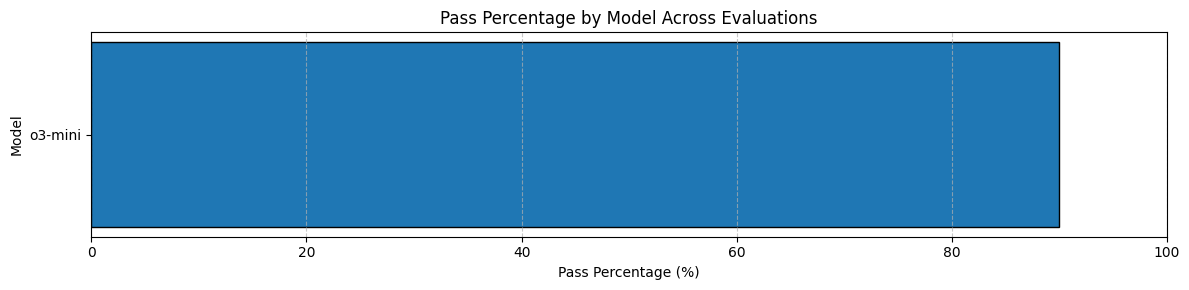

Fetching scores...

Score Summary Table:
Model         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
 None sarcasm-grader-90f2f57b          6.25      3.00      8.00            3.90            4.75            7.00            8.00            8.00


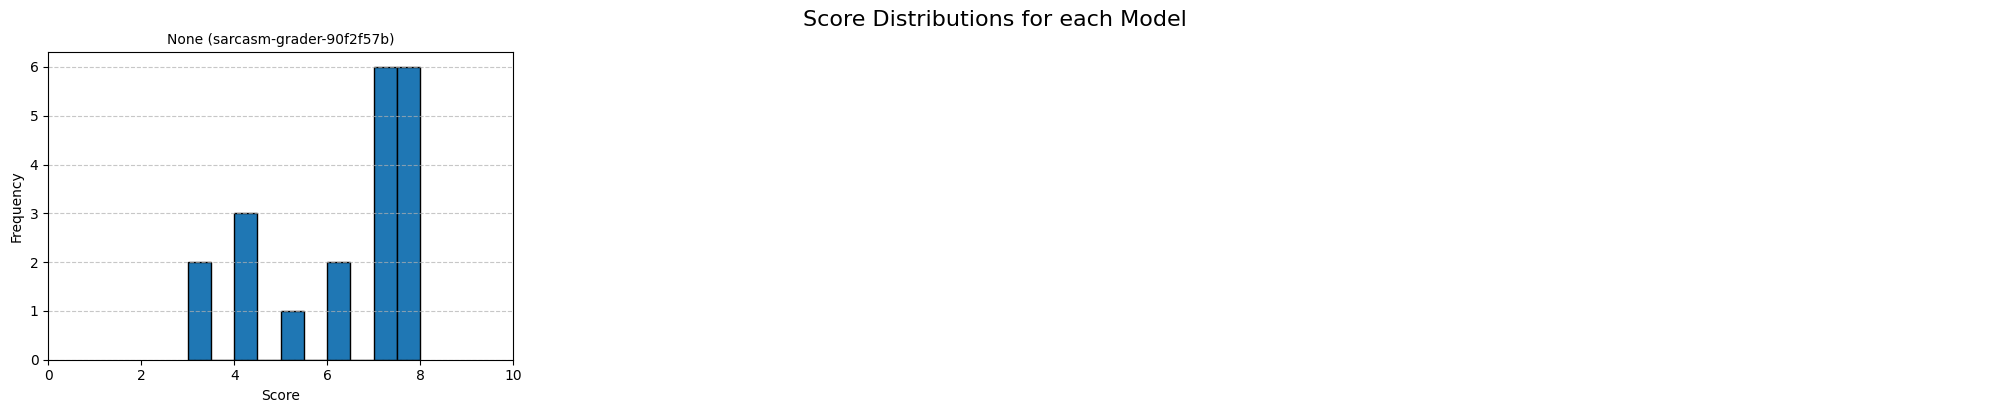

In [11]:
# We've got a handy script for rendering the results from an Evaluations Runs. Let's
# eyeball this stuff. It uses the Evals API to retrieve the scores and plot them.
from scripts.eval_utils import display_evaluation_summary

display_evaluation_summary(client, [grader_eval.id], x_range=(0, 10))

# We should see that our grader generally thinks our "gold standard" is pretty
# sarcastic. This is where we'd iterate on tuning the grader, making sure we
# clearly capture features for it to score, etc. We're keeping it simple for now.

### 🤔 So how's it looking?
Ok! Not bad if we consider our *gold standard* data as generally "good" quality
sarcasm. The Grader thinks these are decent examples with nothing below a `2.0` in
this case and with the *p90* score being `6.0` (this varies with each run of the
notebook, but it tends to land around here).

## 2. Baseline Testing of our Base Models
At this point we've done two things (hopefully!):

1. Developed a Grader we feel is fit for our task.
2. Learned how to construct and submit an Eval and Run.

> ℹ️ If you aren't confident in (2), this is a good time to go re-read the above.

### Generating our Dataset
The real beauty of this type of distillation is we don't have to kill ourselves
to create a dataset! We really only need to generate the end-user's side of the
prompt and not the model's side, making this _so much simpler._

Since our agent usecase here is 📎Clippy, we just need some simple questions a
user of our application might ask. A model like `GPT-4.1` can do this for us with
a prompt like:

```
Generate 100 question and answer pairs that might be used in a quiz game. Output
the pairs in JSONL with the following schema:

{ "question": <the question>, "answer": <the answer> }

Try not to create duplicates!
```

> Seriously, this is how I created `qa.jsonl`. You can use Github Copilot right
> inside Visual Studio Code to generate it and also detect/remove duplicates
> until you have 500 rows.

Let's take a peek at the data in [qa.jsonl](./qa.jsonl):


In [12]:
# We've previously generated 500 Question/Answer pairs. Note that they are only
# focused on factual answers. We're not trying to provide any sarcasm here, just
# facts...and honestly we're not going to use the answers anyways...but you might
# use them if you had another grader that checked for gold standard answers.
import json

qa = []
with open("./qa.jsonl", "r") as f:
    for line in f.readlines():
        qa.append(json.loads(line))

print(f"Number of Q/A pairs: {len(qa)}")
for i in range(3):
    print(qa[i])

Number of Q/A pairs: 500
{'question': 'What is the freezing point of water in Fahrenheit?', 'answer': '32.'}
{'question': 'Which famous physicist developed the theory of relativity?', 'answer': 'Albert Einstein.'}
{'question': "Who wrote the novel '1984'?", 'answer': 'George Orwell'}


We now need to split this into two sets:

1. A set for **baseline** testing (`qa_baseline`)
2. A set for **validation** after fine-tuning (`qa_validation`)

A simple 80/20 split here is good because the point of the validation set here is to have
a totally _different_ test to use post-training that has _zero overlap_ with what we'll
be using to train our student.

In [13]:
# Now let's split these into two sets: our baseline set and our validation set. We'll just split
# them in half for now. 

# First we'll randomize it to maybe prove a point that this isn't totally staged 😜
from random import shuffle
shuffle(qa)

# Now we split 80/20.
split_at = int(len(qa) * 0.8)
qa_baseline = qa[:split_at]
qa_validation = qa[split_at:]

# Check it.
print(f"{len(qa_baseline)} pairs for baseline testing, {len(qa_validation)} for validation.")

400 pairs for baseline testing, 100 for validation.


Let's upload our baseline dataset.

First, we'll write it to disk both to let you inspect it, but also because the OpenAI SDK
really prefers to upload data file files. 🙃

> Yeah, if you're a Python dev and know how to make Files-like objects from data in-memory,
> _sorry_, but the SDK will barf.

In [14]:
# Now we'll upload our baseline dataset and prepare our Evaluation. We need to save the data
# to disk first for...reasons...because of the OpenAI SDK. That's fine.
filename = f"./sarcasm-baseline-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_baseline:
        json.dump(row, f)
        f.write("\n")

baseline_file = None
with open(filename, "rb") as f:
    baseline_file = client.files.create(purpose="evals", file=f)
    baseline_file = client.files.wait_for_processing(baseline_file.id)

print(f"Created baseline file:\n{baseline_file.to_json(indent=2)}")

Created baseline file:
{
  "id": "file-ec72c2ec38dc4bf08937ee2d69cf5a80",
  "bytes": 33245,
  "created_at": 1765377055,
  "filename": "sarcasm-baseline-90f2f57b.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### Defining our Baseline Evaluation
Most of this will look similar to above from section 1 where we evaluated our Grader.

There are some key differences:

1. The prompt template now uses `{{sample.output_text}}` because we'll be using the
   base model (the model under test) to generate the answer to the user's question.
2. Because we're mixing _both_ the provided dataset file with generated responses,
   we have to make some slight tweaks to our data source definition (`DATA_SOURCE`).

Other than that, this is pretty similar.

In [15]:
# We'll now build out the Evaluation details. In this case, we'll *generate* responses
# using a base model, unlike before where we used the pre-canned results just to test
# the grader.

# We'll use a simple system prompt to show how distillation and fine-tuning let us
# get away without overly complex prompt engineering.
SYSTEM_PROMPT = "Clippy is a factual chatbot that is also sarcastic."

# We'll use a flee of base models as our baseline, including `o3` (our grader).
BASE_MODELS = [
    "DeepSeek-V3.1",
    "gpt-4.1",
    "gpt-4.1-mini",
    "gpt-4.1-nano",
    "gpt-4o",
    "gpt-4o-mini",
    "Ministral-3B",
]

# The prompt we'll grade will look like this pattern. Similar to before, but now we're
# going to use {{sample.output_text}} to substitute what the model under test generates.
USER_PROMPT = """
Q: {{item.question}}
A: {{sample.output_text}}
"""

# Input to our grader remains the same as before, but we reproduce it here for context.
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# The schema and data source are similar, but with one major difference noted below.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    },
}
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}

# Same testing criteria, reproduced again for context.
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}

# We create one Evaluation for *all* our base models. Each model is tested in a
# distinct Run that we'll define next.
baseline_eval = client.evals.create(
    name=f"sacarsm-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"⚖️ Created baseline eval {baseline_eval.id}")



⚖️ Created baseline eval eval_693984204a7c8191b08abdc67b5d5e23


Now instead of a single Run, we submit _one Run per base model_.

This part is **new**, so let's look at it closely.

Each Run has its own data source defined. Like with the Grader evaluation where
we finally said _which_ file to use for a test dataset, we're not providing both
a prompt template _and_ a reference to the test dataset.

1. `source` -- looks like what we did previously, referencing our test data by
   file id.
2. `input_messages` -- provides our prompt template, looking similar to how we
   defined the Grader prompt previously. Note, however, we're now using our
   `SYSTEM_PROMPT` (the simple 1-liner Clippy one) and wiring in the test data
   as the user's input.

> ℹ️ An astute reader will notice _we're not using the `answer` field_ from our
> test data. Yup! In this demo, we don't. You _could_ extend the grader to use
> that as "ground truth" for scoring the accuracy. Exercise left to you, my
> friend!

> ⚠️ Attention!
> There's one thing to call out and that's the `sampling_params`. This lets us
> provide tuning of the chat completion parameters to the model under test. In
> this case, we're tuning the max completion tokens.
> 
> However, there are two things to note:
> 1. We use a different value depending on if it's a reasoning model being tested
>    or if it's a GPT model. (I'm not sure if this matters?)
> 2. More importantly, Azure OpenAI has a 🐛bug where we need to specificy it as
>    `max_completions_tokens` and not `max_completion_tokens`. Note the lack of
>    the `s`.

In [16]:
# Each run gets its own data source definition as it needs to specify a different
# model deployment to use for generation. The template is the prompt template
# sent to the model under test. It uses the simple Clippy system prompt and for
# the user input, we use the "question" from the baseline Q&A data file.
baseline_runs = []
for model in BASE_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": baseline_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=baseline_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for eval {baseline_eval.id}")
    baseline_runs.append(run)

🏃‍➡️ Created run evalrun_69398420f92081919db1b05086cd59ce for eval eval_693984204a7c8191b08abdc67b5d5e23
🏃‍➡️ Created run evalrun_69398421b4308191bc33dfac7567f082 for eval eval_693984204a7c8191b08abdc67b5d5e23
🏃‍➡️ Created run evalrun_6939842251f08191b1c8a9e4c5d0b2b1 for eval eval_693984204a7c8191b08abdc67b5d5e23
🏃‍➡️ Created run evalrun_69398422f7508191a52bfb35d10a2542 for eval eval_693984204a7c8191b08abdc67b5d5e23
🏃‍➡️ Created run evalrun_69398423c1008191b859c069dbce521e for eval eval_693984204a7c8191b08abdc67b5d5e23
🏃‍➡️ Created run evalrun_693984246064819180e8989ca09c597a for eval eval_693984204a7c8191b08abdc67b5d5e23
🏃‍➡️ Created run evalrun_6939842511a48191a67a392e04471fc1 for eval eval_693984204a7c8191b08abdc67b5d5e23


Waiting is always the hardest part. What can I say?

This can take 15-20 minutes depending on your TPM limits. Maybe more. Maybe less.

In [17]:
# We now have to wait for our half-dozen or so Runs to finish. Twiddle your thumbs a bit!
from IPython.display import clear_output
import time

start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in baseline_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(baseline_runs)):
        baseline_runs[i] = client.evals.runs.retrieve(eval_id=baseline_eval.id, run_id=baseline_runs[i].id)
        print(f"🏃‍➡️ Run {baseline_runs[i].name}: {baseline_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(baseline_runs)} runs completed!")

🏃‍➡️ Run DeepSeek-V3.1-90f2f57b: completed
🏃‍➡️ Run gpt-4.1-90f2f57b: completed
🏃‍➡️ Run gpt-4.1-mini-90f2f57b: completed
🏃‍➡️ Run gpt-4.1-nano-90f2f57b: completed
🏃‍➡️ Run gpt-4o-90f2f57b: completed
🏃‍➡️ Run gpt-4o-mini-90f2f57b: completed
🏃‍➡️ Run Ministral-3B-90f2f57b: completed
⏱️ Elapsed time: 8 minutes 1 seconds
🏁 All 7 runs completed!


### Interpreting our Baseline Results
Now we get to see our winner and loser!

We'll use the same plotting function as before to look at _pass percentage_ and the
individual score distributions for each model.

What we want to do here is:
1. Identify the clear winner to designat our *teacher*.
2. Identify the clear loser to designate our *student*.

Recall our general hypothesis here is:

> A larger, more robust model will excel at our task out of the box at the cost of
> typically more $'s per token and often higher latency (time-to-first-token).
>
> A smaller, less robust model will perform poorly out of the box, but will provide
> a better $/token price-point and often much lower latency.
>
> The ideal model for our agent will have the lowest $/token and latency, while
> achieving acceptable scores.

Our goal, as a reminder, is to take that fast, cheap model and make it perform
**as well as the slower, more expensive model**.

> 😜 Better, Faster, Cheaper: Pick 3!

Get Evaluation Runs: eval_693984204a7c8191b08abdc67b5d5e23

Combined Evaluation Summary
                                  Run ID               Run Name         Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID           Evaluation Name
evalrun_69398420f92081919db1b05086cd59ce DeepSeek-V3.1-90f2f57b DeepSeek-V3.1 completed           93.750000                 3.00 eval_693984204a7c8191b08abdc67b5d5e23 sacarsm-baseline-90f2f57b
evalrun_69398421b4308191bc33dfac7567f082       gpt-4.1-90f2f57b       gpt-4.1 completed           84.750000                 5.25 eval_693984204a7c8191b08abdc67b5d5e23 sacarsm-baseline-90f2f57b
evalrun_693984246064819180e8989ca09c597a   gpt-4o-mini-90f2f57b   gpt-4o-mini completed           80.000000                 2.75 eval_693984204a7c8191b08abdc67b5d5e23 sacarsm-baseline-90f2f57b
evalrun_6939842251f08191b1c8a9e4c5d0b2b1  gpt-4.1-mini-90f2f57b  gpt-4.1-mini completed           74.686717                 4.00 eval_693984

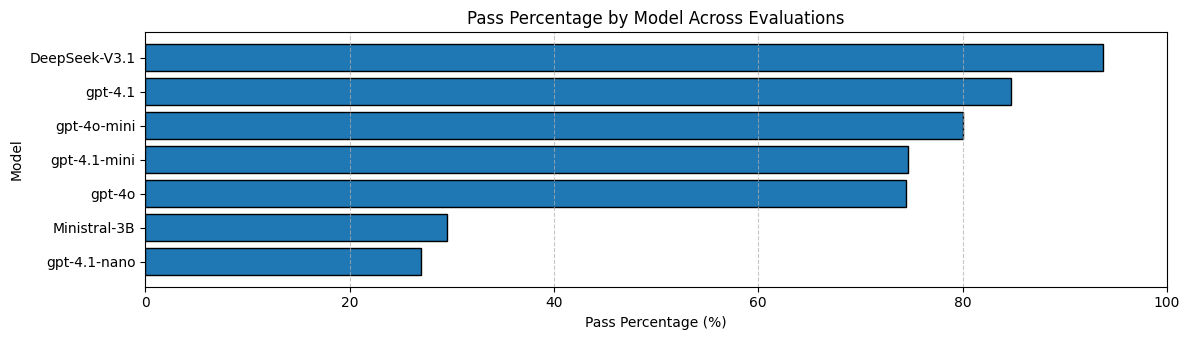

Fetching scores...

Score Summary Table:
        Model           Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
DeepSeek-V3.1 sacarsm-baseline-90f2f57b          7.07      0.00     10.00            5.00            7.00            8.00            8.00            8.00
      gpt-4.1 sacarsm-baseline-90f2f57b          5.80      0.00      9.00            3.00            5.00            6.00            7.00            8.00
  gpt-4o-mini sacarsm-baseline-90f2f57b          5.54      0.00      9.00            3.00            4.00            6.00            7.00            8.00
       gpt-4o sacarsm-baseline-90f2f57b          5.26      0.00      9.00            3.00            3.00            6.00            7.00            8.00
 gpt-4.1-mini sacarsm-baseline-90f2f57b          5.18      0.00      9.00            3.00            3.00            6.00            7.00            8.00
 gpt-4.1-nano sacarsm-baseline-90f2

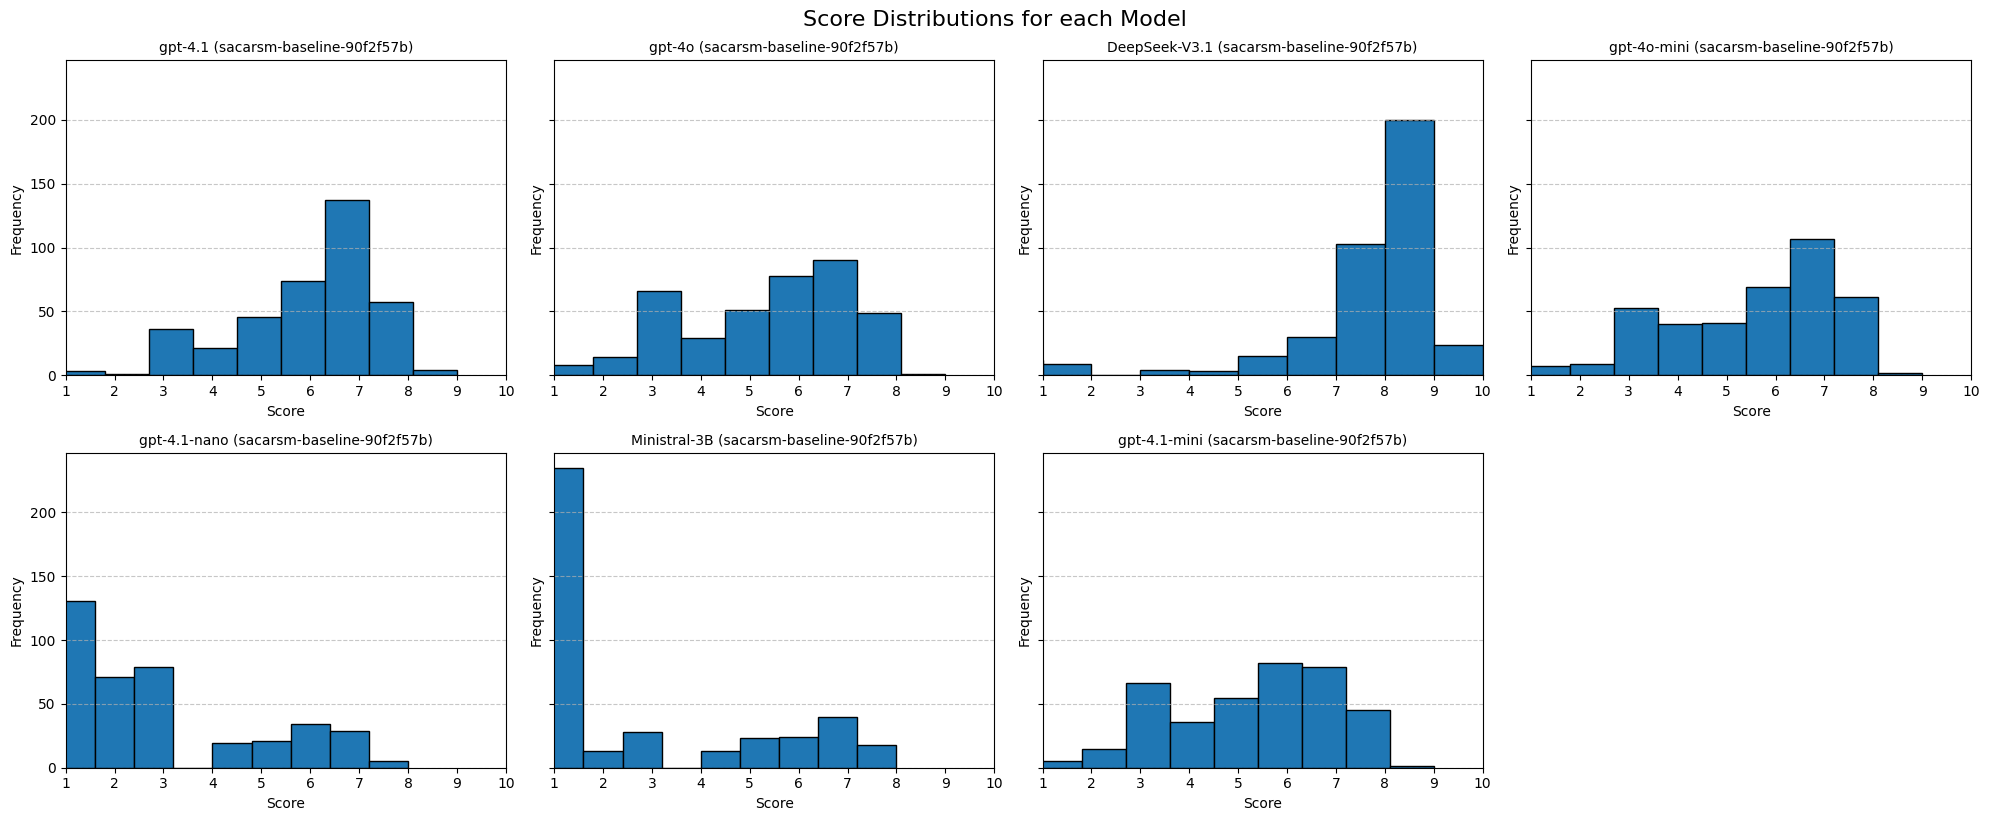

In [18]:
# Let's visualize our evaluation and identify the best and worst performers.
display_evaluation_summary(client, [baseline_eval.id], x_range=(1, 10))


You'll notice we have a very clear winner and a very clear loser.

- `DeepSeek-V3.1` -- consistently scores the highest both in terms of passing scores,
  but also generates generates a lot of high scores.
- `Ministral-3B` -- higher average score than `gpt-4.1-nano`, but has the most scores
  of `1`. Just an embarassment!

But let's hold that thought for a moment. Visually we can see this, but remember what
we want to do here is find not just the _best performing model_, but we need it's best
_example responses_.



## 4. 🧪 Distilling from the Teacher
Let's look at all our models again, this time via code, and find just the _excellent_
responses that scored `6.0` or higher.

> ℹ️ This part gets a bit technical! We'll be doing some data engineering on the fly
> as we analyze the excellent responses. This is maybe the more complex Python in this
> entire notebook as it works around some limitations with the Evaluations API, but
> buckle up and I promise it's worth it.

What we're going to do is query each Run, look at the Run's _individual results_,
collect just the "excellent" ones, and while we're doing so we'll be
_transforming them into chat completions_.

Then it's as simple as seeing which model had the most "excellent" scores and
declaring our winner.

In [19]:
# We'll find the model that generated the most "excellent" (>= 6.0) examples of sarcasm.
CUTOFF = 6.0
HIGH_SCORES = dict([(m, []) for m in BASE_MODELS])

# Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# and pre-format them into chat completions format to save time later.
#
# This part is honestly a bit tricky...we're extracting the prompts and responses for the
# model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
for run in baseline_runs:
    pages = client.evals.runs.output_items.list(run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            if result.score >= CUTOFF:
                generated = result.sample["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:] # drops the "Q: "
                answer = generated[-1]
                messages = [
                    { "role": "system", "content": SYSTEM_PROMPT },
                    { "role": "user", "content": question },
                    { "role": "assistant", "content": answer },
                ]
                HIGH_SCORES[run.model].append({ "messages": messages })

# Time to find the winner! Obviously, this is probably o3...
winning_model = ""
winning_cnt = 0
for key in HIGH_SCORES.keys():
    if len(HIGH_SCORES[key]) > winning_cnt:
        winning_model = key
        winning_cnt = len(HIGH_SCORES[key])
        
print(f"😜 Ok! Let's use {winning_model}. It had {winning_cnt} excellent responses.")

😜 Ok! Let's use DeepSeek-V3.1. It had 357 excellent responses.


We now take _just the Teacher's excellent responses_ and construct our training data.

We should well over 100 examples if all goes well (based on previous testing of this notebook),
so let's give it a train/test split:

1. Split the data in-memory.
2. Write the training and validation data out as JSONL to disk.
3. Upload them via the Files API.

In [20]:
# Before we go any further, let's turn our collected excellent responses into our
# training and validation fine-tuning datasets. Like before, we have to write these
# to disk and then upload them via the Files API.
training_filename = f"sarcasm-training-{UNIQUE_ENOUGH_KEY}.jsonl"
validation_filename = f"sarcasm-validation-{UNIQUE_ENOUGH_KEY}.jsonl"

# Make an 80/20 split to form our training/validation data.
split_at = int(len(HIGH_SCORES[winning_model]) * 0.80)
training_data = HIGH_SCORES[winning_model][:split_at]
validation_data = HIGH_SCORES[winning_model][split_at:]
print(f"Split into {len(training_data)} training / {len(validation_data)} validation rows.")

# Create and upload the training data.
with open(training_filename, "w") as f:
    for message in training_data:
        json.dump(message, f)
        f.write("\n")
with open(training_filename, "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)
print(f"🏋️‍♂️ Created training file:\n{training_file.to_json(indent=2)}")

# Create and upload the validation data.
with open(validation_filename, "w") as f:
    for message in validation_data:
        json.dump(message, f)
        f.write("\n")
with open(validation_filename, "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")
    validation_file = client.files.wait_for_processing(validation_file.id)
print(f"📋 Created validation file:\n{validation_file.to_json(indent=2)}")

Split into 285 training / 72 validation rows.
🏋️‍♂️ Created training file:
{
  "id": "file-8289de70b4af4de98f2136dcd694e0ec",
  "bytes": 120909,
  "created_at": 1765377614,
  "filename": "sarcasm-training-90f2f57b.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}
📋 Created validation file:
{
  "id": "file-8d808872611d45b1b1d38221d4e777ae",
  "bytes": 30810,
  "created_at": 1765377620,
  "filename": "sarcasm-validation-90f2f57b.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


## 5. 🏋️‍♂️ Training the Students
We've got our training dataset, so let's get to fine-tuning!

We've chosen `Ministral-3B` and `gpt-4.1-nano` as the students because they are desperately
in the need of some help as shown by its benchmarking.

We'll create a job _suffix_ that identifies our teacher model for posterity and include that
unique-enough key from before so if you want to run this notebook again you can have two
different fine-tuning jobs to compare.

> ℹ️ Look at the use of `extra_body` as a parameter! We're telling Azure OpenAI to try
> using Global Training for our job. If you want to learn more about Global Training, check
> out the orginal [announcement](https://aka.ms/Build25/FTGlobalAndDev) from **Build 2025**.

Note that we're not tuning hyper-parameters here for our job and just using defaults. That
is an exercise left for you, dear reader!

In [21]:
# Submit our Ministral-3B training job.
TEACHER_MODEL = winning_model
STUDENT_MODEL = "ministral-3b"
SUFFIX = f"sarcasm-{TEACHER_MODEL}-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

ministral_job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    extra_body={ "trainingType": "globalstandard" },
    method={
        "type": "supervised",
        "supervised": {
            "hyperparameters": {
                "n_epochs": 50,  # Ministral-3B benefits from a high epochs value.
            }
        }
    }
)
print(f"👨‍🔬 Created fine-tuning job:\n{ministral_job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-22fdc4d28e9e4b80b78b30daeb76cc00",
  "created_at": 1765377627,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 1.0,
    "n_epochs": 50
  },
  "model": "Ministral-3B",
  "object": "fine_tuning.job",
  "seed": 170999531,
  "status": "pending",
  "training_file": "file-8289de70b4af4de98f2136dcd694e0ec",
  "validation_file": "file-8d808872611d45b1b1d38221d4e777ae",
  "estimated_finish": 1765468527,
  "method": {
    "type": "supervised",
    "supervised": {
      "hyperparameters": {
        "batch_size": -1,
        "learning_rate_multiplier": 1.0,
        "n_epochs": 50
      }
    }
  },
  "suffix": "sarcasm-DeepSeek-V31-90f2f57b",
  "trainingType": "globalStandard"
}


For `gpt-4.1-nano`, we can take advantage of the new *Developer* training tier
that schedules our job on spot capacity at a 50% discount!

In [22]:
# Now we start training! Submit our fine-tuning job to teach 4.1-nano new tricks.
TEACHER_MODEL = winning_model
STUDENT_MODEL = "gpt-4.1-nano-2025-04-14"
SUFFIX = f"sarcasm-{TEACHER_MODEL}-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

nano_job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    extra_body={ "trainingType": "developerTier" },
    # We will use default hyperparameters for this job.
)
print(f"👨‍🔬 Created fine-tuning job:\n{nano_job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-3c27f78ad2c141719573c550300bb791",
  "created_at": 1765377628,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 0.1,
    "n_epochs": -1
  },
  "model": "gpt-4.1-nano-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 1003399446,
  "status": "pending",
  "training_file": "file-8289de70b4af4de98f2136dcd694e0ec",
  "validation_file": "file-8d808872611d45b1b1d38221d4e777ae",
  "estimated_finish": 1765471227,
  "suffix": "sarcasm-DeepSeek-V31-90f2f57b",
  "trainingType": "developerTier"
}


Fine-tuning, like Evaluations, take time. Now's a good time to go catch up on emails ✉️,
walk your dog 🐕, or take a nap 😴. We can poll the training status to know when we can
proceed further in the notebook.

In [23]:
# Wait for our FT job to complete. You may want to go work on some other tasks for now 😜
from IPython.display import clear_output
import time

start_time = time.time()

while any([j.status not in ["succeeded", "failed", "cancelled"] for j in [nano_job, ministral_job]]):
    time.sleep(10)
    nano_job = client.fine_tuning.jobs.retrieve(nano_job.id)
    ministral_job = client.fine_tuning.jobs.retrieve(ministral_job.id)
    clear_output(wait=True)
    print(f"👨‍🔬 gpt-4.1-nano job {nano_job.id}: {nano_job.status}")
    print(f"👨‍🔬 Ministral-3B job {ministral_job.id}: {ministral_job.status}")
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if nano_job.status == "succeeded" and ministral_job.status == "succeeded":
    print(f"🏁 Fine-tuning finished!")
else:
    raise RuntimeError(f"Fine-tuning job did not complete successfully (status={status})")

👨‍🔬 gpt-4.1-nano job ftjob-3c27f78ad2c141719573c550300bb791: succeeded
👨‍🔬 Ministral-3B job ftjob-22fdc4d28e9e4b80b78b30daeb76cc00: succeeded
⏱️ Elapsed time: 57 minutes 53 seconds
🏁 Fine-tuning finished!


Once the jobs complete, we should eyeball the metrics. Here's what an example
should look like:

`TODO: INSERT IMAGE`

If our models are learning, you should see the _training loss_ decreasing.
This gives us a sense of if the model learned something, but it **doesn't** tell us
if the model is fit for production!

## 6. 🧑‍⚖️ Judging our Students against their Peers
Shipping a new model to production right now would be truly a YOLO moment and I
cannot recommend it.

What we really need to do now is go back and benchmark it against the original
`Ministral-3B` and `gpt-4.1-nano` base models.

Remember how we split that initial Q&A dataset into two parts? The `qa_validation`
file contains unseen questions for our models that could not possible appear in the
training data, so it's the perfect check to answer the question if we actually
moved the needle.

### 🚢 Deploying our New Models
Foundry requires you to "deploy" a model in order to have an endpoint to call it,
so let's do that.

We need to reach for a different SDK, though, but no worries! The Azure Cognitive
Services SDK let's us talk to the Azure OpenAI control plane to deploy things
without having to leave this comfy notebook.

> ⚠️ The code below uses a `DefaultAzureCredential`. The easiest way to make sure
> one exists is to have installed and authenticated the Azure CLI tooling.
>
> See: https://learn.microsoft.com/en-us/cli/azure/install-azure-cli?view=azure-cli-latest

For `gpt-4.1-nano`, we'll use the `Developer` tier available for Azure OpenAI
Fine-Tuned models as it's purpose built for model candidate evaluation: you only pay
per token at the same base model rates! ([Learn more](https://aka.ms/Build25/FTGlobalAndDev)!)

For Ministral-3B, we'll use `Global Standard` as `Developer` isn't yet ready while
the model is in Public Preview.

In [24]:
# Now we need to deploy our fine-tuned model. We'll use Developer Tier to keep
# costs under control for evaluation.

# We can't do this with the OpenAI SDK, so we need to reach for the Azure SDK.
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient
from azure.mgmt.cognitiveservices.models import Deployment, DeploymentProperties, DeploymentModel

cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID"),
)

# Define our Deployments. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_CONFIGURATION = [
    {
        "name": f"ministral-3b-distilled-{UNIQUE_ENOUGH_KEY}",
        "format": "Ministral AI",
        "model": ministral_job.fine_tuned_model,
        "sku": "GlobalStandard",
    },
    {
        "name": f"gpt-4.1-nano-distilled-{UNIQUE_ENOUGH_KEY}",
        "format": "OpenAI",
        "model": nano_job.fine_tuned_model,
        "sku": "DeveloperTier",
    },
]

DEPLOYMENTS = []
for d in DEPLOYMENT_CONFIGURATION:
    deployment = cogsvc_client.deployments.begin_create_or_update(
        resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
        account_name=os.environ.get("FOUNDRY_PARENT_RESOURCE"),
        deployment_name=d["name"],
        deployment={
            "properties": {
                "model": {
                    "format": d["format"],
                    "name": d["model"],
                    "version": "1",
                },
            },
            "sku": {"capacity": 100, "name": d["sku"]},
        },
    )
    print(f"🛳️ Submitted deployment {d['name']}")
    DEPLOYMENTS.append(deployment)

🛳️ Submitted deployment ministral-3b-distilled-90f2f57b
🛳️ Submitted deployment gpt-4.1-nano-distilled-90f2f57b


Deployments, like Evaluations and Training, are not instaneous, but they are typically
a lot faster! `Ministral-3B` typically will deploy in 3-5 minutes, so maybe don't walk
away from your desk just yet 😜.

In [27]:
# Wait for our deployment to finish provisioning.
start_time = time.time()

STATUS = [d.status() for d in DEPLOYMENTS]
while any([s not in ["Succeeded", "Failed"] for s in STATUS]):
    print(f"🛳️ Provisioning {STATUS}")
    print("⏱️Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
    STATUS = [d.status() for d in DEPLOYMENTS]
    time.sleep(5)
    clear_output(wait=True)
    
print(f"🏁 Provisioning finished!")


🏁 Provisioning finished!


### ⬆️ Uploading the Validation Data
This should be old-hat by now! We'll take the in-memory validatation data (`qa_validation`)
and create a dataset via the Files API.

In [28]:
# Now we'll upload our post-training validation dataset and prepare our final Evaluation.
# We need to save the data to disk first, again for...reasons.
filename = f"./sarcasm-posttraining-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_validation:
        json.dump(row, f)
        f.write("\n")

posttraining_file = None
with open(filename, "rb") as f:
    posttraining_file = client.files.create(purpose="evals", file=f)
    posttraining_file = client.files.wait_for_processing(posttraining_file.id)


### 🏃 Creating Runs to make our Students Compete with the Base Models
Here's where Evaluations really shine ✨!

We _could_ reuse our baseline evaluation from before and just add new Runs so all the
results are in one place and easily viewable.

In this case, we'll keep it simple and create a new Evaluation primarily because the
visualization code already has color-coding based on Eval, not Run and I'm too lazy
to rewrite it further 😜.

Most of this is repeat, in fact we could have reused thigns like `DATA_SOURCE`,
`TESTING_CRITERIA`, etc. but restate them below for completeness. Same can be said
for the Runs.

*However*, we'll focus on just comparing our new models to their base models and also add
in the teacher as sort of a control. We're testing with totally new data here, unseen by
any of our models, so what we expect to see is:

1. The base `Ministral-3B` and `gpt-4.1-nano` perform poorly again.
2. The teacher performs well and on-par with the previous baseline.
3. The new student models outperform their respective base models.


In [31]:
# Now we create a final Eval using our post-training dataset that doesn't overlap with the
# original distillation and training dataset. This lets us judge our new model based on
# data it hasn't seen before. We'll also through in one of our better performing base
# models as a control.
POST_EVAL_MODELS = [d["name"] for d in DEPLOYMENT_CONFIGURATION] + ["gpt-4.1-nano", "Ministral-3B", TEACHER_MODEL]

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}
posttraining_eval = client.evals.create(
    name=f"sarcasm-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"Created eval {posttraining_eval.id}")

# Now add our runs.
postraining_runs = []
for model in POST_EVAL_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": posttraining_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
    }
    run = client.evals.runs.create(
        name=f"{model}", 
        eval_id=posttraining_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for {posttraining_eval.id}")
    postraining_runs.append(run)


Created eval eval_693996f5adac8191a606b12700d6118f
🏃‍➡️ Created run evalrun_693996f640588191a6d2723f8d53adb5 for eval_693996f5adac8191a606b12700d6118f
🏃‍➡️ Created run evalrun_693996f706ec8191b0096ec9a8305ffd for eval_693996f5adac8191a606b12700d6118f
🏃‍➡️ Created run evalrun_693996f7a04881918725f5a01dfc964b for eval_693996f5adac8191a606b12700d6118f
🏃‍➡️ Created run evalrun_693996f83c488191b358c15ae875ec33 for eval_693996f5adac8191a606b12700d6118f
🏃‍➡️ Created run evalrun_693996f95cb081918c16ae9f8926f64c for eval_693996f5adac8191a606b12700d6118f


Again, we wait! ⏱️

In [32]:
# Again, we wait for our runs to finish.
start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in postraining_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(postraining_runs)):
        postraining_runs[i] = client.evals.runs.retrieve(eval_id=posttraining_eval.id, run_id=postraining_runs[i].id)
        print(f"🏃‍➡️ Run {postraining_runs[i].name}: {postraining_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(postraining_runs)} runs completed!")

🏃‍➡️ Run ministral-3b-distilled-90f2f57b: completed
🏃‍➡️ Run gpt-4.1-nano-distilled-90f2f57b: completed
🏃‍➡️ Run gpt-4.1-nano: completed
🏃‍➡️ Run Ministral-3B: completed
🏃‍➡️ Run DeepSeek-V3.1: completed
⏱️ Elapsed time: 1 minutes 44 seconds
🏁 All 5 runs completed!


### 📊 Interpreting the Post-Training Results
Let's first look at _just the new Evaluation_ to see if our new model outperforms its
competition (`4.1-nano` and `4.1`).

Get Evaluation Runs: eval_693996f5adac8191a606b12700d6118f

Combined Evaluation Summary
                                  Run ID                        Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                       Evaluation Name
evalrun_693996f95cb081918c16ae9f8926f64c                   DeepSeek-V3.1   DeepSeek-V3.1 completed           97.000000                  0.0 eval_693996f5adac8191a606b12700d6118f sarcasm-posttrain-evaluation-90f2f57b
evalrun_693996f706ec8191b0096ec9a8305ffd gpt-4.1-nano-distilled-90f2f57b gpt-4.1-nano-di completed           83.838384                  1.0 eval_693996f5adac8191a606b12700d6118f sarcasm-posttrain-evaluation-90f2f57b
evalrun_693996f640588191a6d2723f8d53adb5 ministral-3b-distilled-90f2f57b ministral-3b-di completed           74.000000                  0.0 eval_693996f5adac8191a606b12700d6118f sarcasm-posttrain-evaluation-90f2f57b
evalrun_693996f83c488191b358c15ae875ec33        

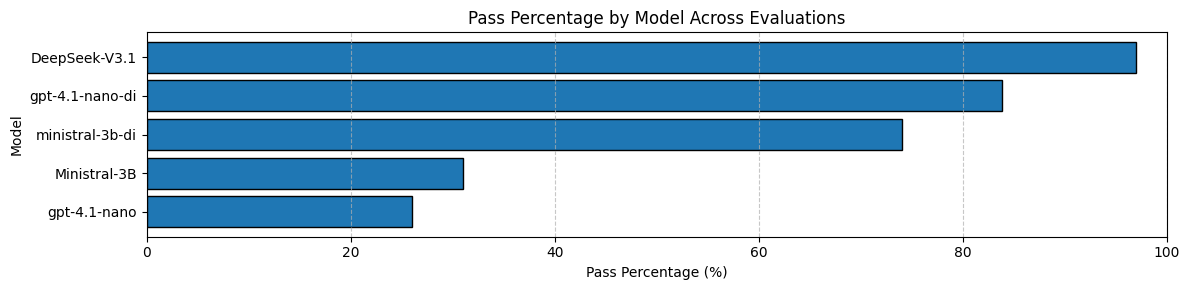

Fetching scores...

Score Summary Table:
          Model                       Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
  DeepSeek-V3.1 sarcasm-posttrain-evaluation-90f2f57b          7.30      1.00      9.00            6.90            7.00            7.50            8.00            8.00
gpt-4.1-nano-di sarcasm-posttrain-evaluation-90f2f57b          6.26      1.00      8.00            1.00            6.00            7.00            8.00            8.00
ministral-3b-di sarcasm-posttrain-evaluation-90f2f57b          5.38      1.00      9.00            1.00            3.00            6.00            7.00            8.00
   gpt-4.1-nano sarcasm-posttrain-evaluation-90f2f57b          2.81      1.00      8.00            1.00            1.00            3.00            4.00            6.00
   Ministral-3B sarcasm-posttrain-evaluation-90f2f57b          2.74      1.00      8.00            1.00            1.00

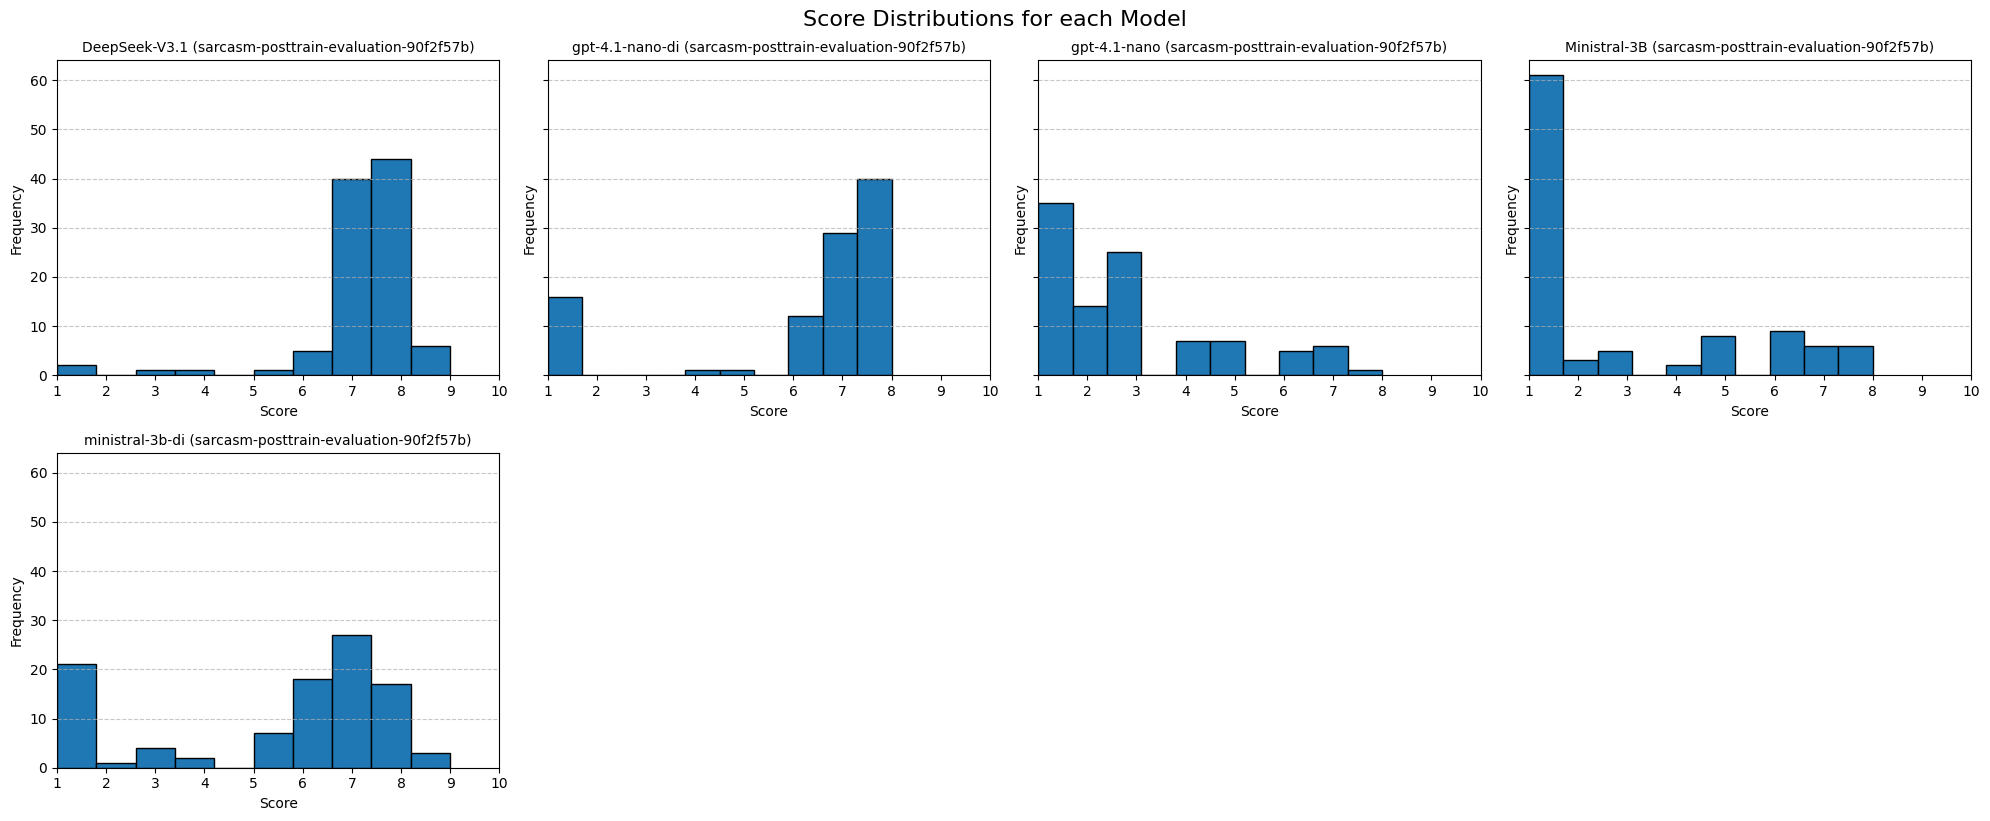

In [33]:
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [posttraining_eval.id], x_range=(1, 10))

Get Evaluation Runs: eval_693984204a7c8191b08abdc67b5d5e23
Get Evaluation Runs: eval_693996f5adac8191a606b12700d6118f

Combined Evaluation Summary
                                  Run ID                        Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                       Evaluation Name
evalrun_693996f95cb081918c16ae9f8926f64c                   DeepSeek-V3.1   DeepSeek-V3.1 completed           97.000000                 0.00 eval_693996f5adac8191a606b12700d6118f sarcasm-posttrain-evaluation-90f2f57b
evalrun_69398420f92081919db1b05086cd59ce          DeepSeek-V3.1-90f2f57b   DeepSeek-V3.1 completed           93.750000                 3.00 eval_693984204a7c8191b08abdc67b5d5e23             sacarsm-baseline-90f2f57b
evalrun_69398421b4308191bc33dfac7567f082                gpt-4.1-90f2f57b         gpt-4.1 completed           84.750000                 5.25 eval_693984204a7c8191b08abdc67b5d5e23             sacarsm-baselin

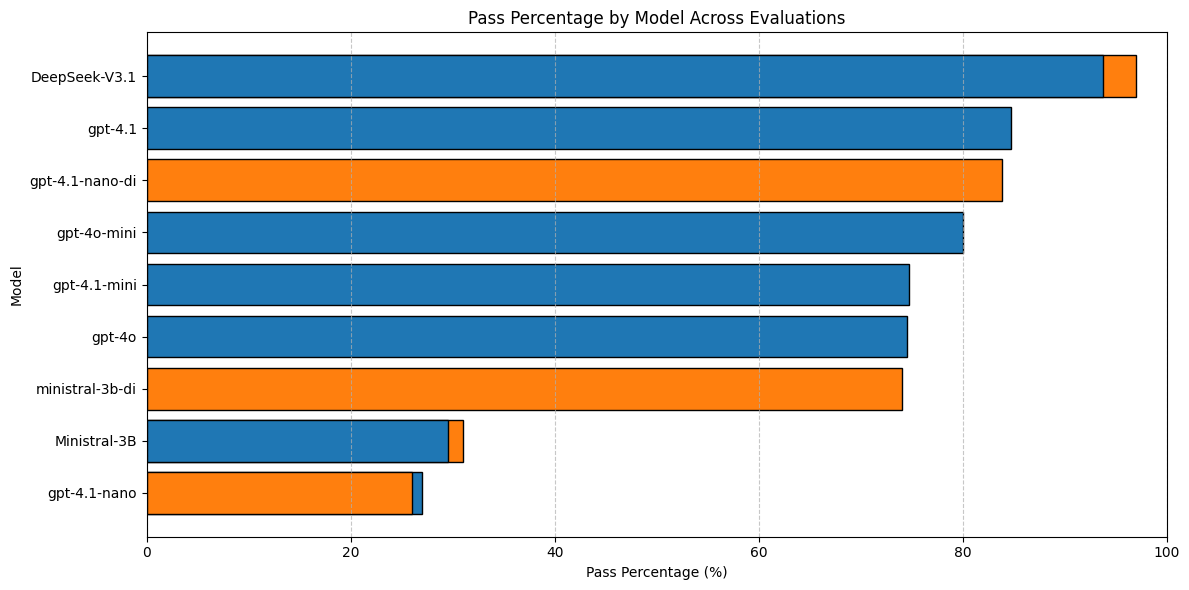

Fetching scores...

Score Summary Table:
          Model                       Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
  DeepSeek-V3.1             sacarsm-baseline-90f2f57b          7.07      0.00     10.00            5.00            7.00            8.00            8.00            8.00
        gpt-4.1             sacarsm-baseline-90f2f57b          5.80      0.00      9.00            3.00            5.00            6.00            7.00            8.00
    gpt-4o-mini             sacarsm-baseline-90f2f57b          5.54      0.00      9.00            3.00            4.00            6.00            7.00            8.00
         gpt-4o             sacarsm-baseline-90f2f57b          5.26      0.00      9.00            3.00            3.00            6.00            7.00            8.00
   gpt-4.1-mini             sacarsm-baseline-90f2f57b          5.18      0.00      9.00            3.00            3.00

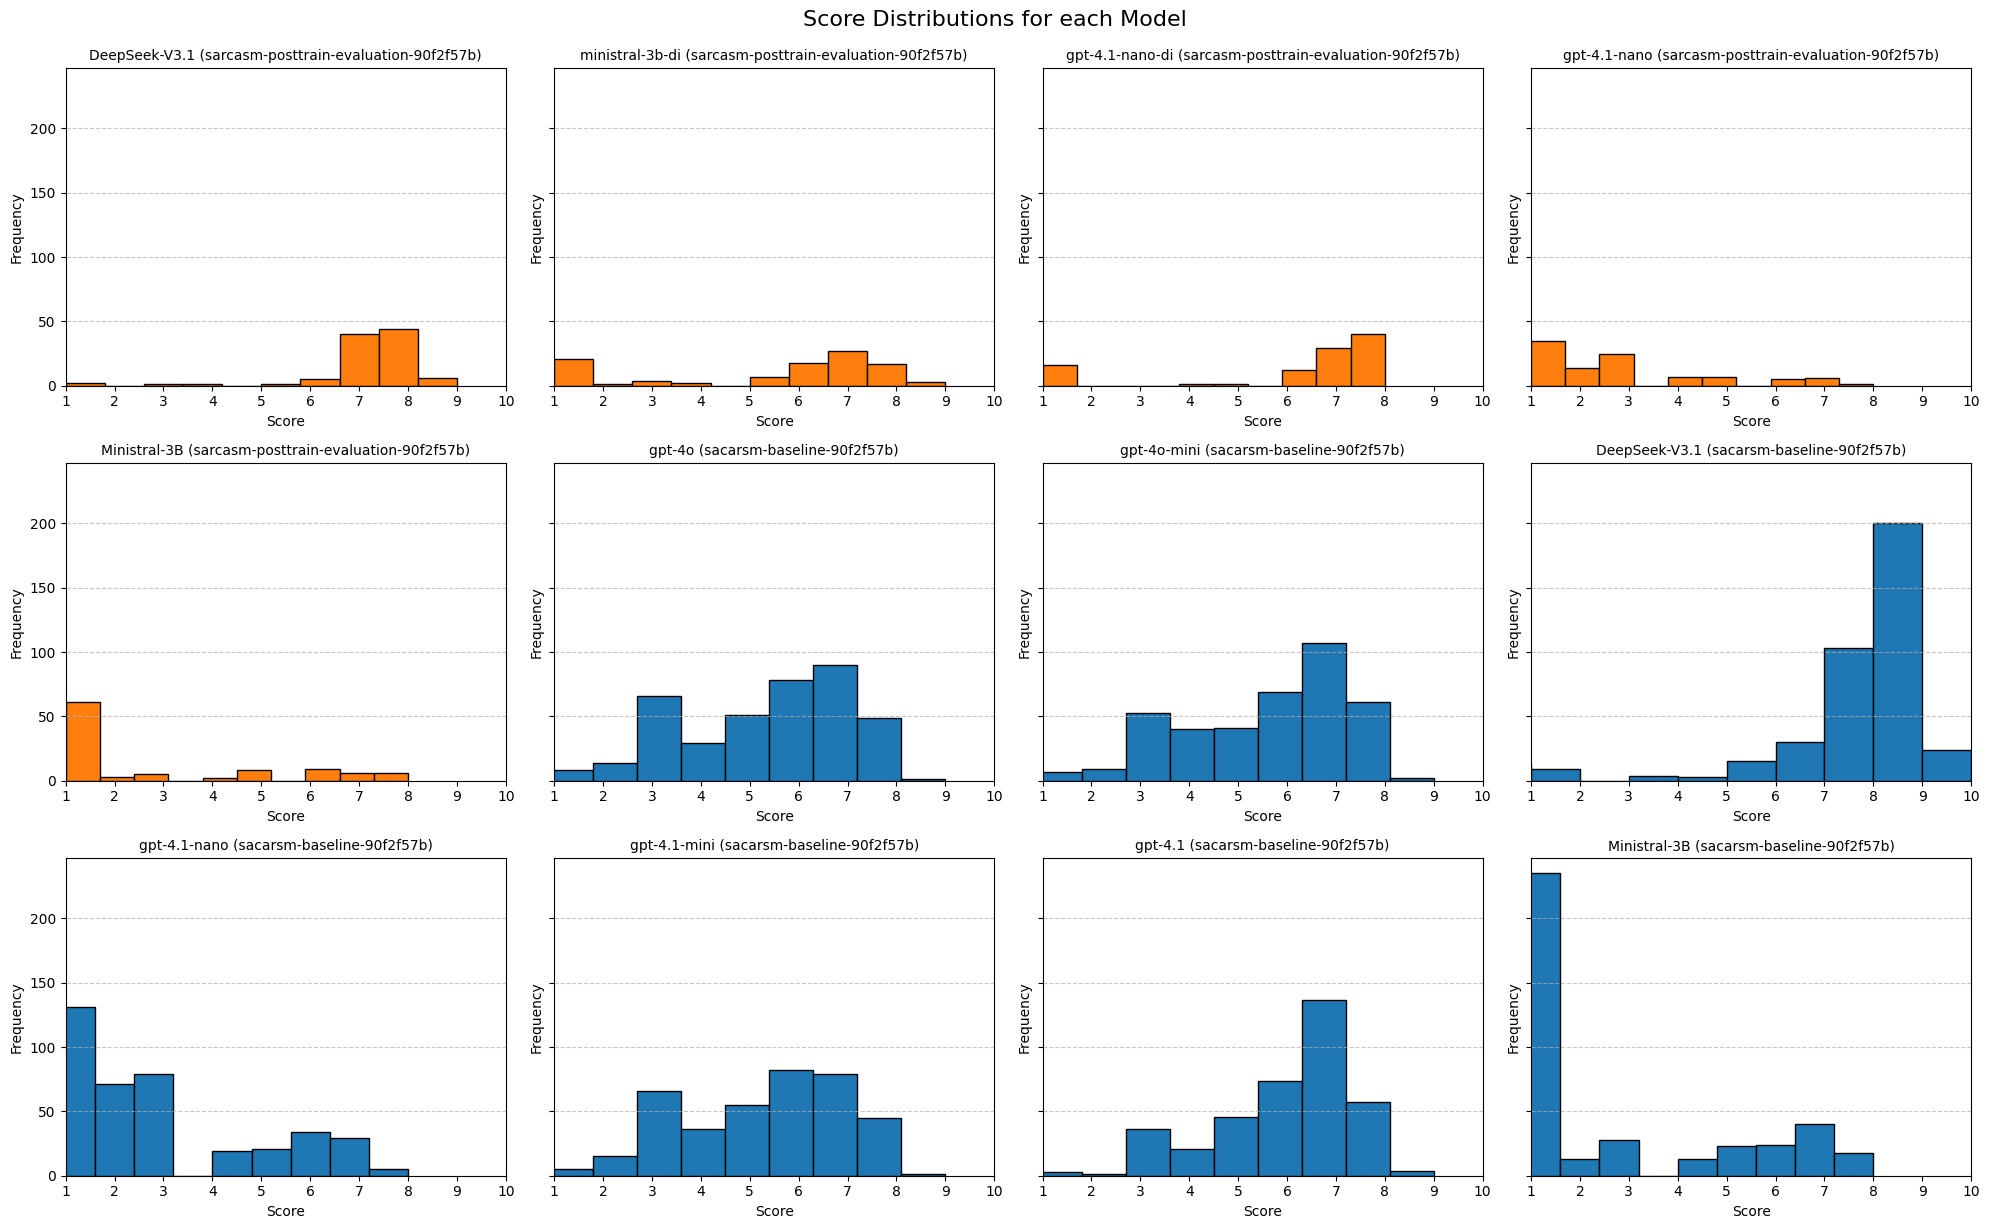

In [34]:
# And now let's put it all together.
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(client, [baseline_eval.id, posttraining_eval.id], x_range=(1, 10))

## 🥳 7. Celebrate or Cry
It _should_ be time to celebrate if all went well!

We can clearly see our new models not only outperforming their base models, but
also competing with larger OpenAI models and DeepSeek!


## 🔚 8. Conclusion
In this notebook we demonstrated **distillation** using Azure OpenAI *Evaluations*
and *Fine Tuning* features.

We used an objective of *adjusting the tone* of a model to meet our needs, in this
case making its responses sarcastic, while preserving accuracy in results, and
*distilled* the native capabilities of a state-of-the-art reasoning model (`o3`)
into a much smaller, non-reasoning model (`4.1-nano`) to let our agent or app
use the smallest model possible while:

- 🤑 minimizing per-token costs
- 🏎️ improve performance (latency)

We did all this:

- without creating training data directly
- without knowing the ideal student model
- only by knowing how to define our Grader

So to wrap it all up:

1. We described the ideal state to our complex reasoning model in the form of
   a few samples we feel are ideal.
2. We described to the reasoning model (grader) how to judge those examples
   to measure their quality.
3. We let Evaluations and Fine Tuning do the rest!




## 🧹 9. Cleanup
If you want to clean up everthing from this notebook, set `cleanup = True` below.

In [ ]:
# Want to clean up your mess? 
cleanup = True

if cleanup:
    # for now, we delete the model deployments as they may incur charges
    for name in [d["name"] for d in DEPLOYMENT_CONFIGURATION]:
        print(f"deleting {name}...")
        poller = cogsvc_client.deployments.begin_delete(
            resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
            account_name=os.environ.get("FOUNDRY_PARENT_RESOURCE"),
            deployment_name=name,
        )
        while not poller.done():
            time.sleep(5)
        print(f"deleted!")
    # todo: delete training data files

deleting ministral-3b-distilled-90f2f57b...
deleted!
deleting gpt-4.1-nano-distilled-90f2f57b...
deleted!
